# Examples of "bundling" dimensions into groups

The diagram below shows valid transitions used to create the sparse structure.

`n1`, `n2`, `n3`, `n4` are how many dimensions are in each group.

### Data of bundled groups
- `HyperSparse(n1)`
  - indices for `n1` dimensions
  - pointers array (or scalar `k` for ELLPACK-like compression)
- `Coord(n2)`
  - indices for `n2` dimensions
- `Sparse(n3)`
  - pointers array (or scalar `k` for ELLPACK-like compression)
- `Full(n4)`
  - N/A

_Note that indices grouped together in this scheme are all the same length, so they can be stored as separate 1-d arrays or a single 2-d array_

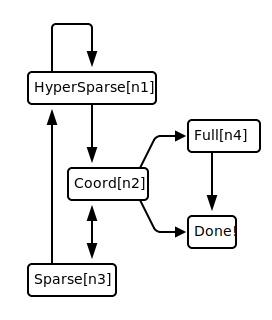

In [1]:
# Valid transitions
import IPython
from sphinxcontrib.svgbob._svgbob import to_svg

IPython.display.SVG(
    to_svg(
        r"""
      .----.
      |    |
      |    v
   .--+------------.
   |HyperSparse[n1]|
   `-------+-------'
      ^    |           .--------.
      |    |       .-->|Full[n4]|
      |    v      /    `--+-----'
      | .--------+.       |
      | |Coord[n2]|       |
      | `--------+'       v
      |    ^      \    .-----.
      |    |       `-->|Done!|
      |    v           `-----' 
   .--+-------.
   |Sparse[n3]|
   `----------'
        """
    )
)

# Examples for rank 4 array

Pass COO-like data to `SparseTensor` with one array of indices for each dimension.

The default is to create CSF sparse data structure where all but the last dimension are doubly compressed.

In [2]:
group_indices = True  # Whether or not to group indices in diagrams below

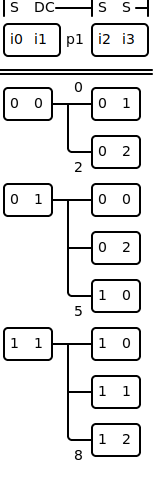

In [3]:
from sparsetensorviz import SparseTensor
import itertools
import IPython

indices = [
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 1],
    [1, 2, 0, 2, 0, 0, 1, 2],
]
sp = SparseTensor(indices, structure="S-DC-S-S", group_indices=group_indices)
# Display as SVG diagram
sp

In [4]:
sp.indices

[array([0, 0, 1]),
 array([0, 1, 1]),
 array([0, 0, 0, 0, 1, 1, 1, 1]),
 array([1, 2, 0, 2, 0, 0, 1, 2])]

In [5]:
sp.pointers

[None, array([0, 2, 5, 8]), None]

In [6]:
# Can also display as ASCII diagram
print(sp)

|S  DC ----|S  S -|
.------.   .------.
|i0 i1 |p1 |i2 i3 |
`------'   `------'
.-----.  0 .-----.
|0  0 |-+--|0  1 |
`-----' |  `-----'
        |  .-----.
        `--|0  2 |
         2 `-----'
.-----.    .-----.
|0  1 |-+--|0  0 |
`-----' |  `-----'
        |  .-----.
        |--|0  2 |
        |  `-----'
        |  .-----.
        `--|1  0 |
         5 `-----'
.-----.    .-----.
|1  1 |-+--|1  0 |
`-----' |  `-----'
        |  .-----.
        |--|1  1 |
        |  `-----'
        |  .-----.
        `--|1  2 |
         8 `-----'


This diagram forms a tree-like structure where the first dimension is on the left and last dimension is on the right.

Index values are in boxes, and pointer values are next to edges.

We can choose how each dimension is compressed with any of the following:
- **`S`, "sparse"**: like COO; indices are "aligned" to the following dimension indices or values.
  - Uses: `indices_i`
- **`C`, "compressed"**: like CSR; fast lookup by index into pointers to the next dimension.
  - Uses: `pointers_i`
  - Makes `pointers_{i-1}` unnecessary
- **`DC`, "doubly compressed"**: like DCSR; store unique index values and pointers to the next dimension.
  - Uses: `pointers_i`, `indices_i`

Currently, the final dimension must be sparse, **`S`**.

Hence, describing the structures of **CSR, CSC, DCSR, and DCSC** give us... CSR, CSC, DCSR, and DCSC (let's address the final "R" and "C" later).

In [7]:
sp.bundled_groups

['HyperSparse(2)', 'Coord(2)']

In [8]:
sp.structure

[sparse, doubly_compressed, sparse, sparse]

In [9]:
sp.abbreviation

'S-DC-S-S'

## Display all sparse structures that are independent of shape

This includes sparse structures that have no "compressed sparse" (**`C`**) dimensions.

Hyphonated connecting lines indicate pointers that don't need stored.

In [10]:
# Helper function
seen_taco = {}


def to_tim(st):
    rv = []
    for gp in st.bundled_groups:
        if "expanded=" in gp:
            return
        num = int(gp[:-1].split("(", 1)[1])
        if gp.startswith("Coord"):
            rv.extend(["index"] * num)
        elif gp.startswith("Full"):
            rv.extend(["full"] * num)
        elif gp.startswith("Sparse"):
            rv.extend(["sparse"] * num)
        elif gp.startswith("Hyper"):
            rv.extend(["index"] * (num - 1))
            rv.append("hyper")
        else:
            raise ValueError(f"Bad group: {gp}")
    return rv


def display_header(st, *, align=False, seen_taco=None):
    key = tuple(st.taco_structure)
    if seen_taco and key in seen_taco:
        seen_text = "  # (seen)"
    else:
        seen_text = ""
        if seen_taco is not None:
            seen_taco[key] = st.structure
    bundled = ", ".join(st.bundled_groups)
    tim_structure = to_tim(st)
    if align:
        if tim_structure is not None:
            widths = [
                max(len(str(x)), len(y), len(z))
                for x, y, z in zip(st.structure, st.taco_structure, tim_structure)
            ]
        else:
            widths = [max(len(str(x)), len(y)) for x, y in zip(st.structure, st.taco_structure)]
        structure = ", ".join(
            str(sparse).rjust(width) for sparse, width in zip(st.structure, widths)
        )
        if tim_structure is None:
            tim_structure = "N/A"
        else:
            tim_structure = (
                "["
                + ", ".join(sparse.rjust(width) for sparse, width in zip(tim_structure, widths))
                + "]"
            )
        taco_structure = ", ".join(
            sparse.rjust(width) for sparse, width in zip(st.taco_structure, widths)
        )
        text = (
            "```\n"
            f"bundled_groups = [{bundled}]\n\n"
            f"tim_structure  = {tim_structure}\n\n"
            f"structure      = [{structure}]\n\n"
            f"taco_structure = [{taco_structure}]{seen_text}\n\n"
            "```"
        )
    else:
        taco_structure = ", ".join(st.taco_structure)
        if tim_structure is None:
            tim_structure = "N/A"
        else:
            tim_structure = "[" + ", ".join(tim_structure) + "]"
        text = (
            "```\n"
            f"bundled_groups = [{bundled}]\n\n"
            f"tim_structure  = {tim_structure}\n\n"
            f"structure      = {st.structure}\n\n"
            f"taco_structure = [{taco_structure}]{seen_text}\n\n"
            "```"
        )
    IPython.display.display(IPython.display.Markdown(text))

# `S-S-S-S`

```
bundled_groups = [Coord(4)]

tim_structure  = [index, index, index, index]

structure      = [sparse, sparse, sparse, sparse]

taco_structure = [compressed-nonunique, singleton, singleton, singleton]

```

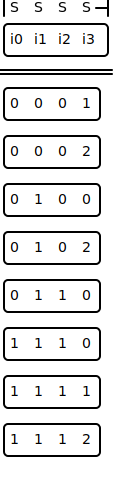

# `S-S-DC-S`

```
bundled_groups = [HyperSparse(3), Coord(1)]

tim_structure  = [index, index, hyper, index]

structure      = [sparse, sparse, doubly_compressed, sparse]

taco_structure = [compressed, singleton, singleton, compressed]

```

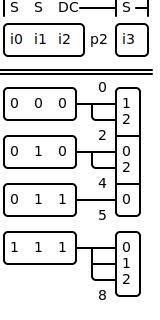

# `S-DC-S-S`

```
bundled_groups = [HyperSparse(2), Coord(2)]

tim_structure  = [index, hyper, index, index]

structure      = [sparse, doubly_compressed, sparse, sparse]

taco_structure = [compressed, singleton, compressed-nonunique, singleton]

```

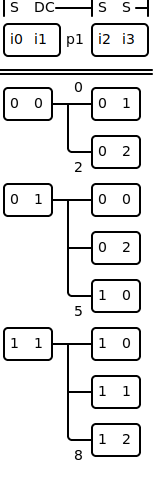

# `S-DC-DC-S`

```
bundled_groups = [HyperSparse(2), HyperSparse(1), Coord(1)]

tim_structure  = [index, hyper, hyper, index]

structure      = [sparse, doubly_compressed, doubly_compressed, sparse]

taco_structure = [compressed, singleton, compressed, compressed]

```

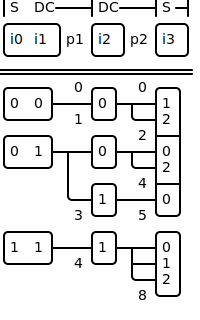

# `DC-S-S-S`

```
bundled_groups = [HyperSparse(1), Coord(3)]

tim_structure  = [hyper, index, index, index]

structure      = [doubly_compressed, sparse, sparse, sparse]

taco_structure = [compressed, compressed-nonunique, singleton, singleton]

```

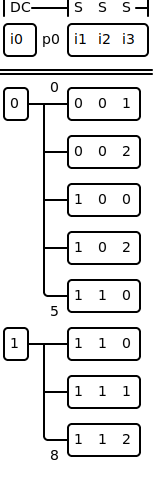

# `DC-S-DC-S`

```
bundled_groups = [HyperSparse(1), HyperSparse(2), Coord(1)]

tim_structure  = [hyper, index, hyper, index]

structure      = [doubly_compressed, sparse, doubly_compressed, sparse]

taco_structure = [compressed, compressed, singleton, compressed]

```

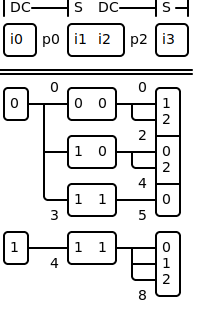

# `DC-DC-S-S`

```
bundled_groups = [HyperSparse(1), HyperSparse(1), Coord(2)]

tim_structure  = [hyper, hyper, index, index]

structure      = [doubly_compressed, doubly_compressed, sparse, sparse]

taco_structure = [compressed, compressed, compressed-nonunique, singleton]

```

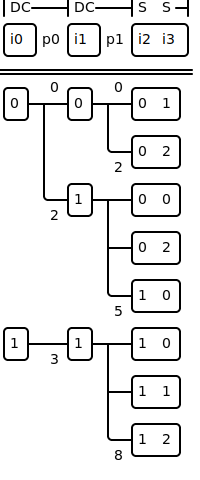

# `DC-DC-DC-S`

```
bundled_groups = [HyperSparse(1), HyperSparse(1), HyperSparse(1), Coord(1)]

tim_structure  = [hyper, hyper, hyper, index]

structure      = [doubly_compressed, doubly_compressed, doubly_compressed, sparse]

taco_structure = [compressed, compressed, compressed, compressed]

```

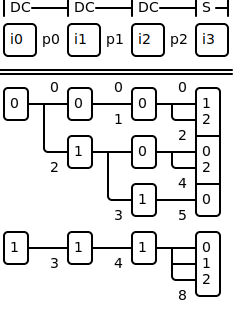

In [11]:
sparsities = ["S", "DC"]
for sparsity in itertools.product(sparsities, sparsities, sparsities, ["S"]):
    structure = "-".join(sparsity)
    IPython.display.display(IPython.display.Markdown(f"# `{structure}`"))
    st = SparseTensor(indices, structure=structure, group_indices=group_indices)
    display_header(st, seen_taco=seen_taco)
    IPython.display.display(st)

## Display sparse structures, `shape=(2, 2, 2, 3)`

Hyphonated boxes indicate indices that don't need stored.

For compressed sparse dimensions, `C`, some repeated pointer values may be skipped if there is no room

# `S-S-C-S`

```
bundled_groups = [Coord(2, expanded=1), Sparse(1), Coord(1)]

tim_structure  = N/A

structure      = [sparse, sparse, compressed, sparse]

taco_structure = [compressed-nonunique, singleton, dense, compressed]

```

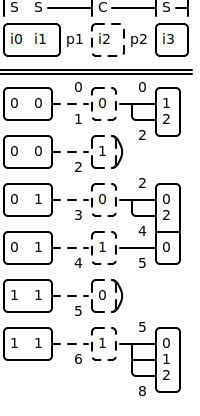

# `S-C-S-S`

```
bundled_groups = [Coord(1, expanded=1), Sparse(1), Coord(2)]

tim_structure  = N/A

structure      = [sparse, compressed, sparse, sparse]

taco_structure = [compressed-nonunique, dense, compressed-nonunique, singleton]

```

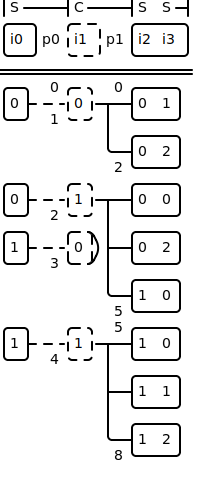

# `S-C-C-S`

```
bundled_groups = [Coord(1, expanded=1), Sparse(2), Coord(1)]

tim_structure  = N/A

structure      = [sparse, compressed, compressed, sparse]

taco_structure = [compressed-nonunique, dense, dense, compressed]

```

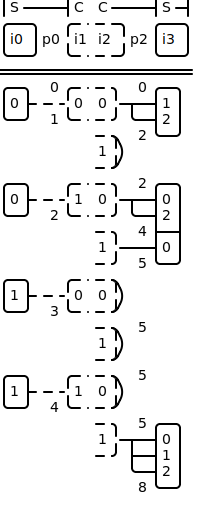

# `S-C-DC-S`

```
bundled_groups = [Coord(1, expanded=1), Sparse(1), HyperSparse(1), Coord(1)]

tim_structure  = N/A

structure      = [sparse, compressed, doubly_compressed, sparse]

taco_structure = [compressed-nonunique, dense, compressed, compressed]

```

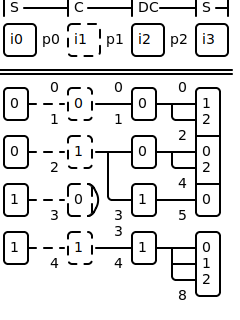

# `S-DC-C-S`

```
bundled_groups = [Coord(2), Sparse(1), Coord(1)]

tim_structure  = [index, index, sparse, index]

structure      = [sparse, doubly_compressed, compressed, sparse]

taco_structure = [compressed, singleton, dense, compressed]

```

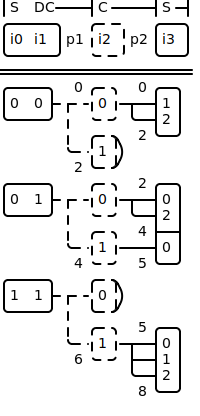

# `C-S-S-S`

```
bundled_groups = [Sparse(1), Coord(3)]

tim_structure  = [sparse, index, index, index]

structure      = [compressed, sparse, sparse, sparse]

taco_structure = [dense, compressed-nonunique, singleton, singleton]

```

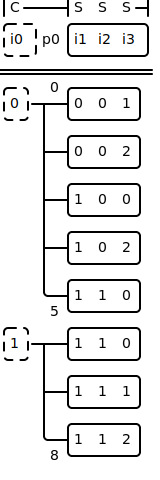

# `C-S-C-S`

```
bundled_groups = [Sparse(1), Coord(1, expanded=1), Sparse(1), Coord(1)]

tim_structure  = N/A

structure      = [compressed, sparse, compressed, sparse]

taco_structure = [dense, compressed-nonunique, dense, compressed]

```

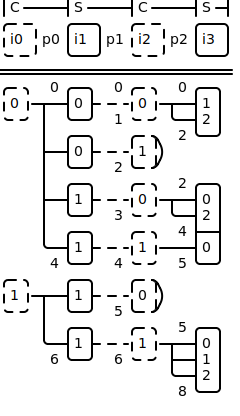

# `C-S-DC-S`

```
bundled_groups = [Sparse(1), HyperSparse(2), Coord(1)]

tim_structure  = [sparse, index, hyper, index]

structure      = [compressed, sparse, doubly_compressed, sparse]

taco_structure = [dense, compressed, singleton, compressed]

```

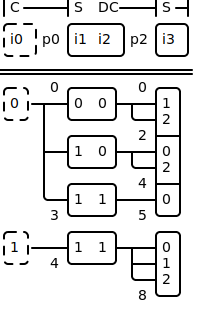

# `C-C-S-S`

```
bundled_groups = [Sparse(2), Coord(2)]

tim_structure  = [sparse, sparse, index, index]

structure      = [compressed, compressed, sparse, sparse]

taco_structure = [dense, dense, compressed-nonunique, singleton]

```

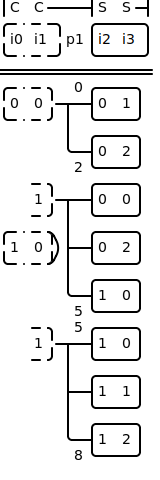

# `C-C-C-S`

```
bundled_groups = [Sparse(3), Coord(1)]

tim_structure  = [sparse, sparse, sparse, index]

structure      = [compressed, compressed, compressed, sparse]

taco_structure = [dense, dense, dense, compressed]

```

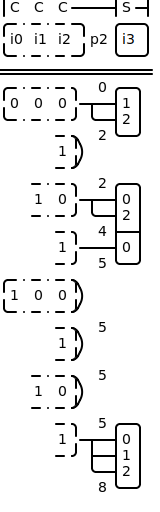

# `C-C-DC-S`

```
bundled_groups = [Sparse(2), HyperSparse(1), Coord(1)]

tim_structure  = [sparse, sparse, hyper, index]

structure      = [compressed, compressed, doubly_compressed, sparse]

taco_structure = [dense, dense, compressed, compressed]

```

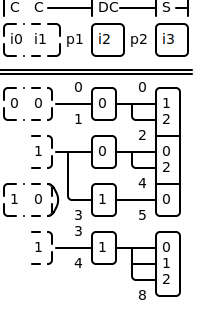

# `C-DC-S-S`

```
bundled_groups = [Sparse(1), HyperSparse(1), Coord(2)]

tim_structure  = [sparse, hyper, index, index]

structure      = [compressed, doubly_compressed, sparse, sparse]

taco_structure = [dense, compressed, compressed-nonunique, singleton]

```

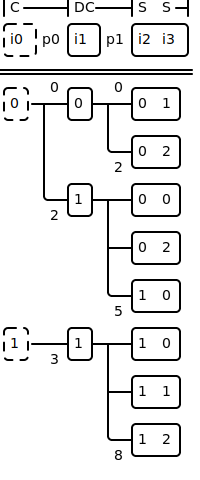

# `C-DC-C-S`

```
bundled_groups = [Sparse(1), Coord(1), Sparse(1), Coord(1)]

tim_structure  = [sparse, index, sparse, index]

structure      = [compressed, doubly_compressed, compressed, sparse]

taco_structure = [dense, compressed, dense, compressed]

```

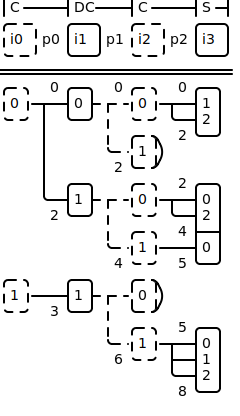

# `C-DC-DC-S`

```
bundled_groups = [Sparse(1), HyperSparse(1), HyperSparse(1), Coord(1)]

tim_structure  = [sparse, hyper, hyper, index]

structure      = [compressed, doubly_compressed, doubly_compressed, sparse]

taco_structure = [dense, compressed, compressed, compressed]

```

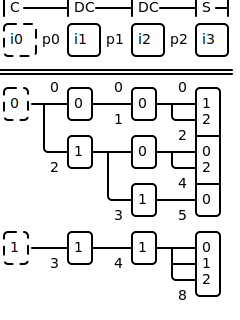

# `DC-S-C-S`

```
bundled_groups = [HyperSparse(1), Coord(1, expanded=1), Sparse(1), Coord(1)]

tim_structure  = N/A

structure      = [doubly_compressed, sparse, compressed, sparse]

taco_structure = [compressed, compressed-nonunique, dense, compressed]

```

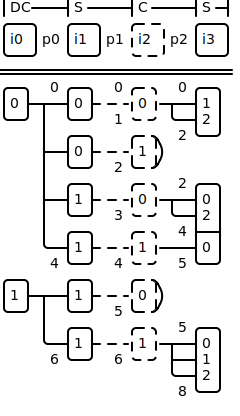

# `DC-C-S-S`

```
bundled_groups = [Coord(1), Sparse(1), Coord(2)]

tim_structure  = [index, sparse, index, index]

structure      = [doubly_compressed, compressed, sparse, sparse]

taco_structure = [compressed, dense, compressed-nonunique, singleton]

```

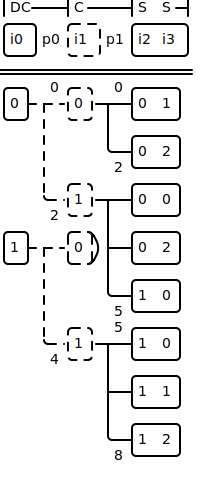

# `DC-C-C-S`

```
bundled_groups = [Coord(1), Sparse(2), Coord(1)]

tim_structure  = [index, sparse, sparse, index]

structure      = [doubly_compressed, compressed, compressed, sparse]

taco_structure = [compressed, dense, dense, compressed]

```

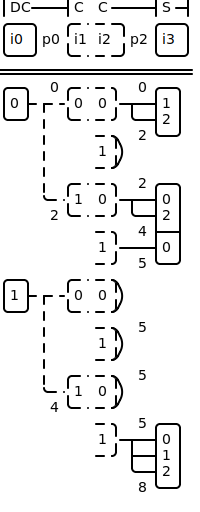

# `DC-C-DC-S`

```
bundled_groups = [Coord(1), Sparse(1), HyperSparse(1), Coord(1)]

tim_structure  = [index, sparse, hyper, index]

structure      = [doubly_compressed, compressed, doubly_compressed, sparse]

taco_structure = [compressed, dense, compressed, compressed]

```

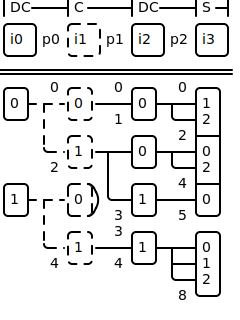

# `DC-DC-C-S`

```
bundled_groups = [HyperSparse(1), Coord(1), Sparse(1), Coord(1)]

tim_structure  = [hyper, index, sparse, index]

structure      = [doubly_compressed, doubly_compressed, compressed, sparse]

taco_structure = [compressed, compressed, dense, compressed]

```

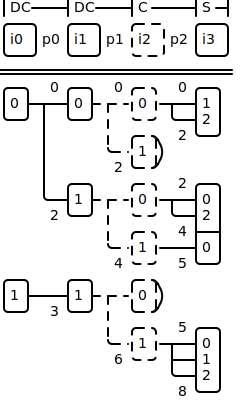

In [12]:
sparsities = ["S", "C", "DC"]
for sparsity in itertools.product(sparsities, sparsities, sparsities, ["S"]):
    if "C" not in sparsity:
        continue
    structure = "-".join(sparsity)
    IPython.display.display(IPython.display.Markdown(f"# `{structure}`"))
    st = SparseTensor(indices, shape=(2, 2, 2, 3), structure=structure, group_indices=group_indices)
    display_header(st)
    IPython.display.display(st)

# voilà!

_Note that `Coord(n, expanded=1)`, which comes from `S-C` combination, is a silly data structure that duplicates data unnecessarily.
`Coord(n)` is strongly preferred._